# Sử dụng SIFT và SVM để phát hiện người trong ảnh

In [33]:
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm


In [34]:
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, (256, 256))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            images.append(img)
    return images

human_dir = "/kaggle/input/human-detection-dataset/human detection dataset/1"
nonhuman_dir = "/kaggle/input/human-detection-dataset/human detection dataset/0"

human_imgs = load_images_from_folder(human_dir)
nonhuman_imgs = load_images_from_folder(nonhuman_dir)

print("Human:", len(human_imgs))
print("Non-human:", len(nonhuman_imgs))


Human: 559
Non-human: 362


In [35]:
sift = cv2.SIFT_create()

def extract_sift_features(images):
    descriptors_list = []
    for img in tqdm(images):
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            descriptors_list.append(descriptors)
    return descriptors_list

human_desc = extract_sift_features(human_imgs)
nonhuman_desc = extract_sift_features(nonhuman_imgs)

print("Example descriptor shape:", human_desc[0].shape)


100%|██████████| 362/362 [00:06<00:00, 51.73it/s]

Example descriptor shape: (132, 128)


In [50]:
print(f"Số ảnh có người: {len(human_imgs)}")
print(f"Số ảnh không có người: {len(nonhuman_imgs)}")
print(f"Tổng số ảnh: {len(human_imgs) + len(nonhuman_imgs)}")

print("\nKích thước vector đặc trưng mỗi ảnh:", X.shape[1])
print("Ma trận đặc trưng tổng:", X.shape)

print("\n=== 5 vector đầu tiên ===")
for i in range(5):
    v = X[i]
    print(f"Vector {i+1}: {v[:10]} ... {v[-10:]}")


Số ảnh có người: 559
Số ảnh không có người: 362
Tổng số ảnh: 921

Kích thước vector đặc trưng mỗi ảnh: 800
Ma trận đặc trưng tổng: (921, 800)

=== 5 vector đầu tiên ===
Vector 1: [0. 0. 1. 0. 0. 0. 1. 0. 0. 0.] ... [0. 1. 0. 0. 0. 2. 1. 1. 0. 0.]
Vector 2: [0. 1. 3. 0. 0. 0. 2. 0. 0. 0.] ... [1. 0. 0. 0. 0. 0. 1. 3. 0. 0.]
Vector 3: [1. 0. 1. 1. 1. 0. 2. 0. 2. 0.] ... [0. 1. 0. 2. 0. 0. 0. 2. 0. 1.]
Vector 4: [1. 0. 0. 1. 1. 1. 4. 0. 1. 3.] ... [0. 2. 0. 1. 0. 0. 2. 0. 0. 0.]
Vector 5: [0. 0. 0. 0. 0. 0. 0. 0. 1. 5.] ... [0. 0. 0. 4. 0. 0. 0. 0. 0. 0.]


In [36]:
# gom descriptors
all_desc = np.vstack(human_desc + nonhuman_desc)

k = 800  # tối ưu cho dataset 900 ảnh
all_desc = np.vstack(human_desc + nonhuman_desc)



kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
kmeans.fit(all_desc)

def build_bow(descriptors, kmeans):
    bow = np.zeros(k)
    clusters = kmeans.predict(descriptors)
    for c in clusters:
        bow[c] += 1
    return bow

X = []
y = []

# humans = label 1
for desc in human_desc:
    X.append(build_bow(desc, kmeans))
    y.append(1)

# non humans = label 0
for desc in nonhuman_desc:
    X.append(build_bow(desc, kmeans))
    y.append(0)

X = np.array(X)
y = np.array(y)

print("Final vector shape:", X.shape)


Final vector shape: (921, 800)


In [37]:
X = []
y = []
index_refs = []   # lưu index ảnh gốc

# humans = label 1
for i, desc in enumerate(human_desc):
    X.append(build_bow(desc, kmeans))
    y.append(1)
    index_refs.append(i)   # index gốc trong image_refs

# non humans = label 0
offset = len(human_desc)
for i, desc in enumerate(nonhuman_desc):
    X.append(build_bow(desc, kmeans))
    y.append(0)
    index_refs.append(offset + i)


In [38]:
# Lưu index ảnh tương ứng
image_refs = human_imgs + nonhuman_imgs


In [39]:
X = np.array(X)
y = np.array(y)
index_refs = np.array(index_refs)


In [40]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, index_refs, test_size=0.2, random_state=42, stratify=y
)

In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [1, 10, 50, 100],
    'gamma': ['scale', 0.01, 0.001, 0.0001]
}

grid = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=3, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best:", grid.best_params_)
svm = grid.best_estimator_

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Best: {'C': 10, 'gamma': 0.0001}
Accuracy: 0.6918918918918919
              precision    recall  f1-score   support

           0       0.64      0.49      0.56        73
           1       0.71      0.82      0.76       112

    accuracy                           0.69       185
   macro avg       0.68      0.66      0.66       185
weighted avg       0.69      0.69      0.68       185



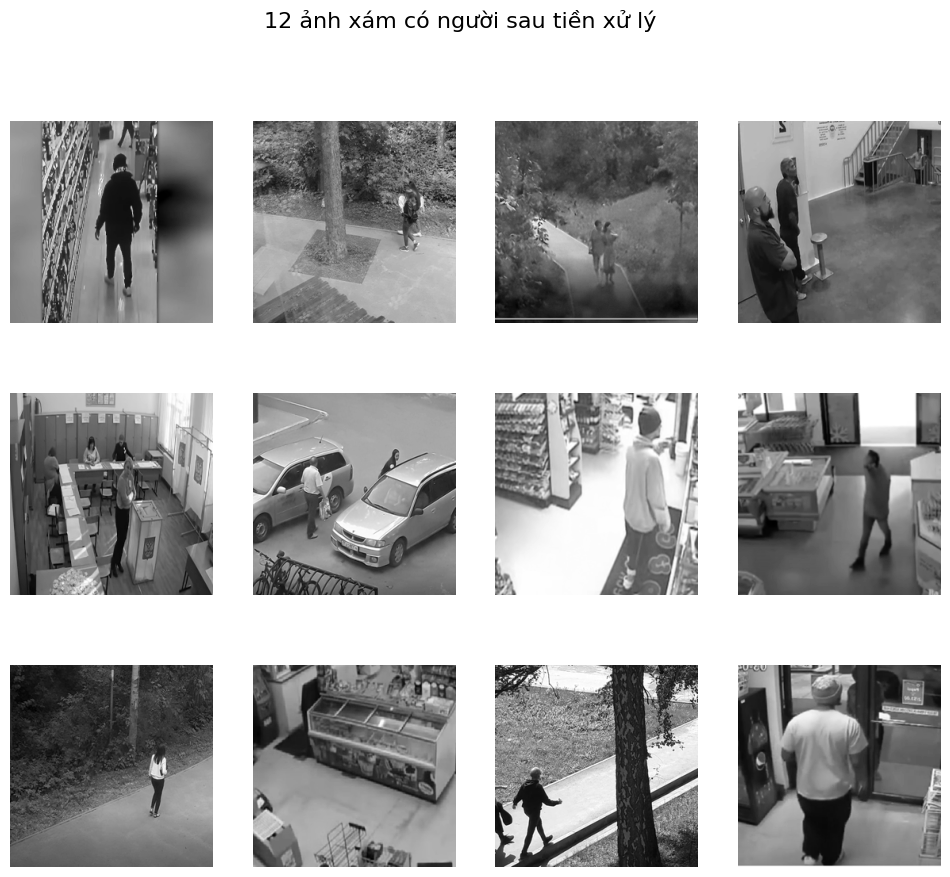

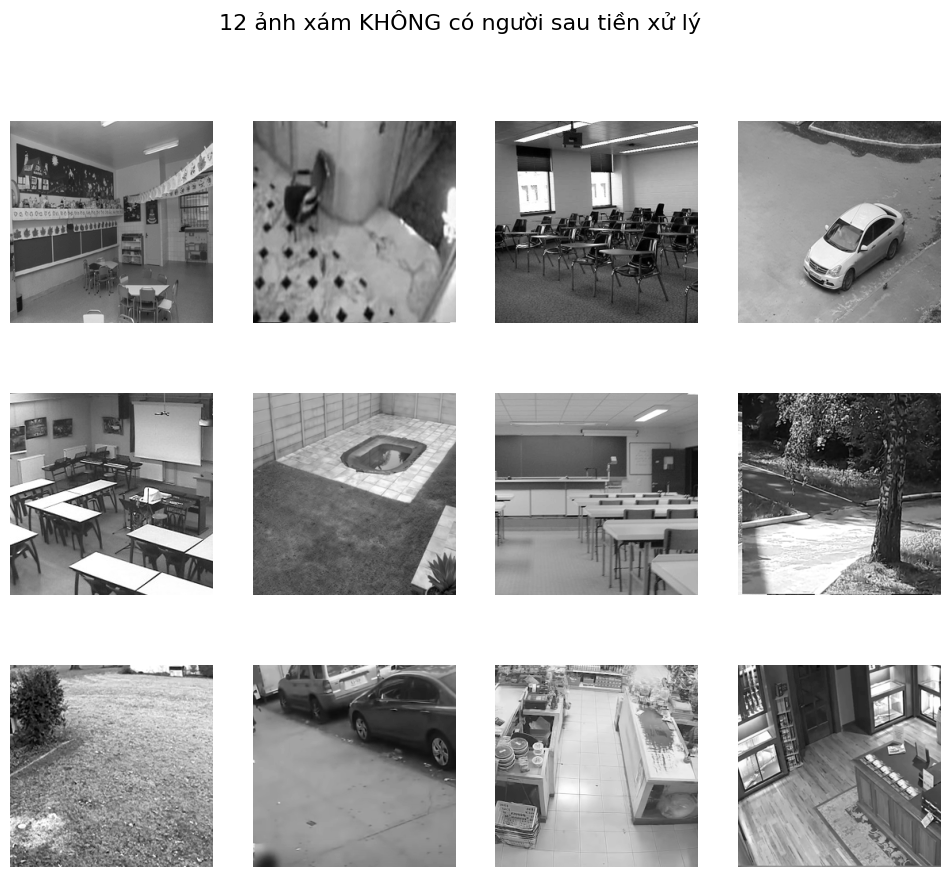

In [42]:
# ==== HIỂN THỊ 12 ẢNH CÓ NGƯỜI ====
import random

sample_human = random.sample(human_imgs, 12)

plt.figure(figsize=(12, 10))
for i, img in enumerate(sample_human):
    ax = plt.subplot(3, 4, i+1)
    ax.imshow(img, cmap="gray")
    ax.axis("off")
plt.suptitle("12 ảnh xám có người sau tiền xử lý", fontsize=16)
plt.show()

# ==== HIỂN THỊ 12 ẢNH KHÔNG CÓ NGƯỜI ====
sample_nonhuman = random.sample(nonhuman_imgs, 12)

plt.figure(figsize=(12, 10))
for i, img in enumerate(sample_nonhuman):
    ax = plt.subplot(3, 4, i+1)
    ax.imshow(img, cmap="gray")
    ax.axis("off")
plt.suptitle("12 ảnh xám KHÔNG có người sau tiền xử lý", fontsize=16)
plt.show()


In [43]:
# ==== PCA GIẢM CHIỀU ====
from sklearn.decomposition import PCA

print("Số chiều ban đầu:", X_train.shape[1])

pca = PCA(n_components=200)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Số chiều sau PCA:", X_train_pca.shape[1])

# ==== SVM SAU PCA ====
svm_pca = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])
svm_pca.fit(X_train_pca, y_train)

y_pred_pca = svm_pca.predict(X_test_pca)

print("Accuracy sau PCA:", accuracy_score(y_test, y_pred_pca))
print(classification_report(y_test, y_pred_pca))


Số chiều ban đầu: 800
Số chiều sau PCA: 200
Accuracy sau PCA: 0.6810810810810811
              precision    recall  f1-score   support

           0       0.66      0.40      0.50        73
           1       0.69      0.87      0.77       112

    accuracy                           0.68       185
   macro avg       0.67      0.63      0.63       185
weighted avg       0.68      0.68      0.66       185



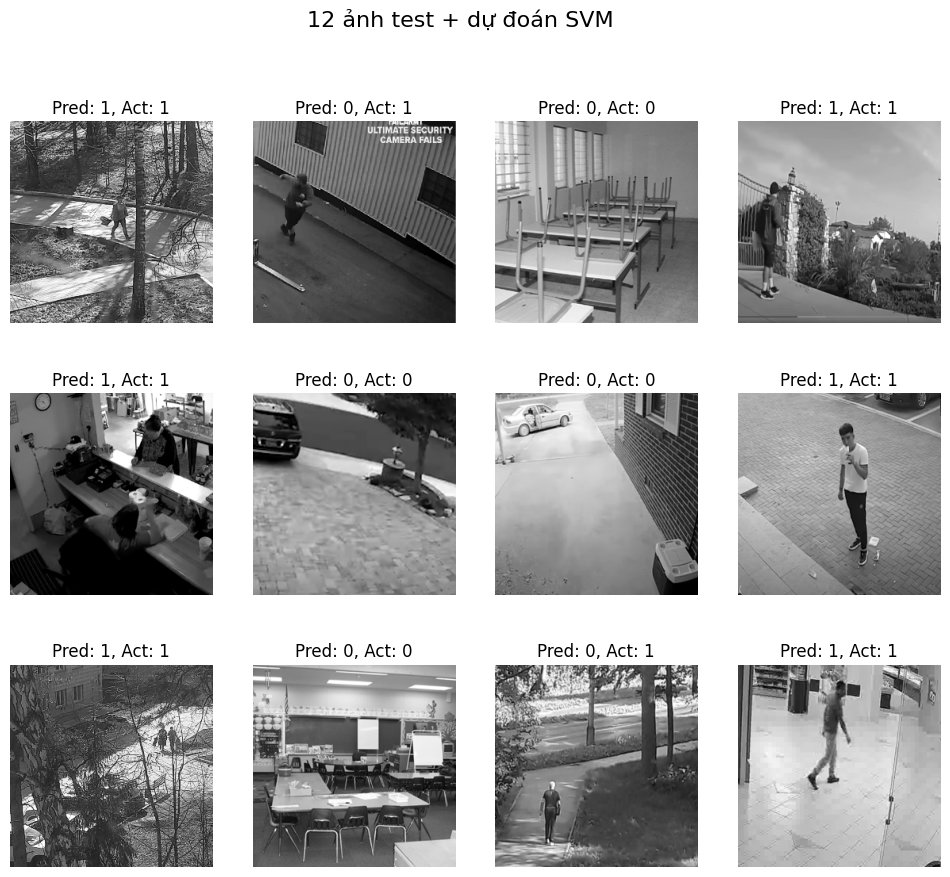

In [44]:
sample_idx = np.random.choice(len(X_test), 12, replace=False)

plt.figure(figsize=(12, 10))
for i, idx in enumerate(sample_idx):

    pred = svm.predict([X_test[idx]])[0]
    true = y_test[idx]

    # Lấy index gốc
    original_index = idx_test[idx]

    # Ảnh gốc đúng
    img = image_refs[original_index]

    ax = plt.subplot(3, 4, i+1)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Pred: {pred}, Act: {true}")
    ax.axis("off")

plt.suptitle("12 ảnh test + dự đoán SVM", fontsize=16)
plt.show()


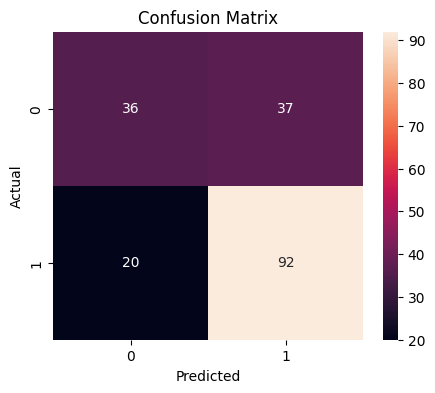

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


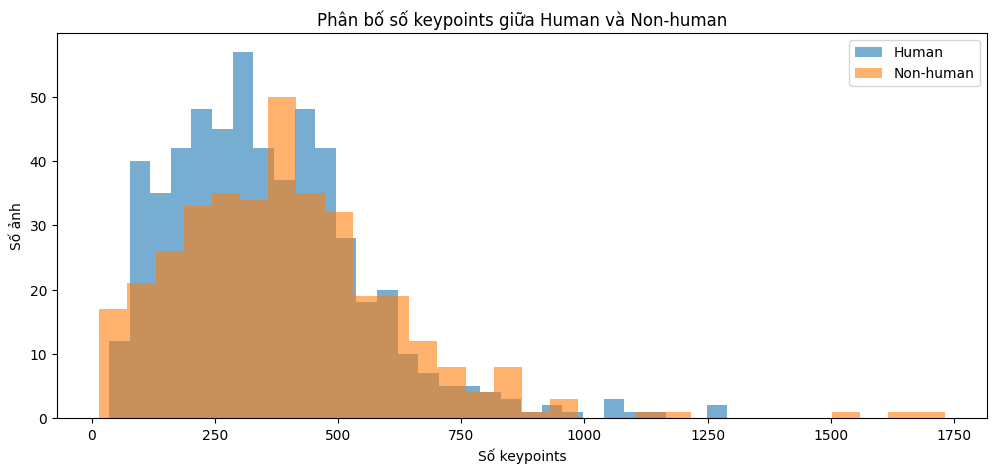

In [46]:
# === THỐNG KÊ KEYPOINTS ===
human_kp = [s.shape[0] for s in human_desc]
nonhuman_kp = [s.shape[0] for s in nonhuman_desc]

plt.figure(figsize=(12,5))
plt.hist(human_kp, bins=30, alpha=0.6, label="Human")
plt.hist(nonhuman_kp, bins=30, alpha=0.6, label="Non-human")
plt.xlabel("Số keypoints")
plt.ylabel("Số ảnh")
plt.legend()
plt.title("Phân bố số keypoints giữa Human và Non-human")
plt.show()


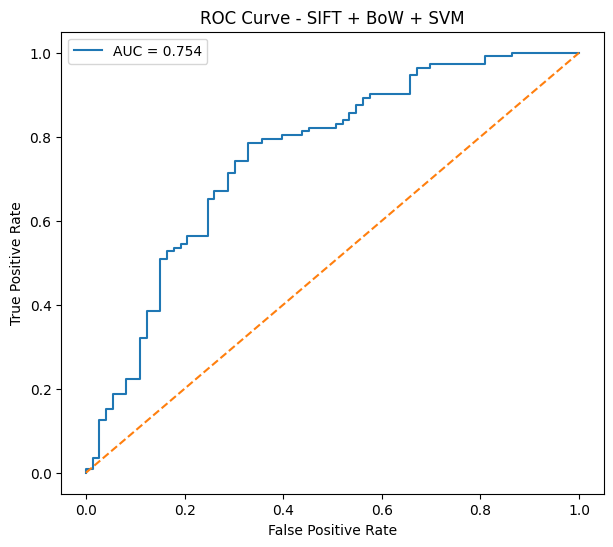

In [47]:
from sklearn.metrics import roc_curve, auc

svm_prob = svm.decision_function(X_test)
fpr, tpr, _ = roc_curve(y_test, svm_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SIFT + BoW + SVM")
plt.legend()
plt.show()


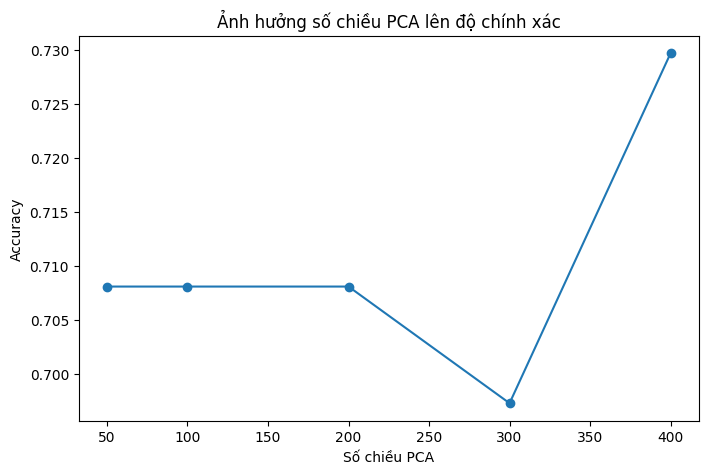

In [48]:
dims = [50, 100, 200, 300, 400]
acc_pca = []

for d in dims:
    pca_tmp = PCA(n_components=d)
    X_train_p = pca_tmp.fit_transform(X_train)
    X_test_p = pca_tmp.transform(X_test)

    svm_tmp = SVC(kernel='rbf', C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])
    svm_tmp.fit(X_train_p, y_train)
    acc_pca.append(accuracy_score(y_test, svm_tmp.predict(X_test_p)))

plt.figure(figsize=(8,5))
plt.plot(dims, acc_pca, marker='o')
plt.xlabel("Số chiều PCA")
plt.ylabel("Accuracy")
plt.title("Ảnh hưởng số chiều PCA lên độ chính xác")
plt.show()


# Một số ảnh bị dự đoán sai

Số lượng dự đoán sai: 57


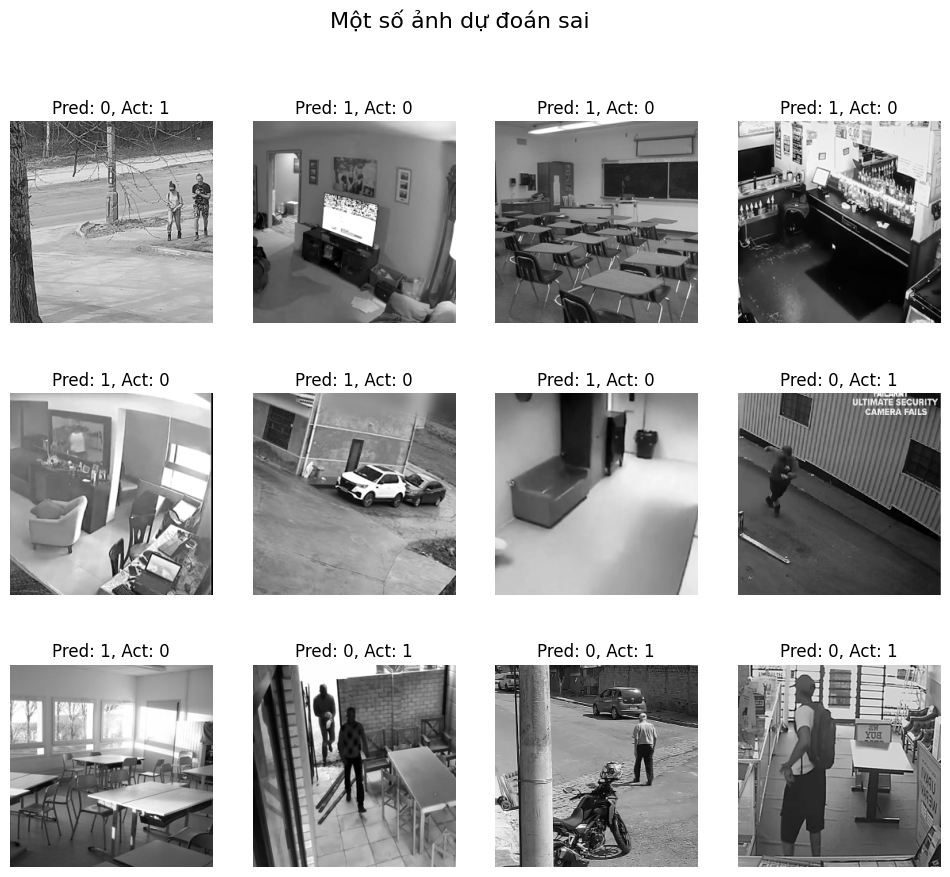

In [49]:
wrong_idx = np.where(y_pred != y_test)[0]
print("Số lượng dự đoán sai:", len(wrong_idx))

sample_wrong = np.random.choice(wrong_idx, min(12, len(wrong_idx)), replace=False)

plt.figure(figsize=(12, 10))
for i, idx in enumerate(sample_wrong):
    original_index = idx_test[idx]
    img = image_refs[original_index]

    ax = plt.subplot(3, 4, i+1)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Pred: {y_pred[idx]}, Act: {y_test[idx]}")
    ax.axis("off")

plt.suptitle("Một số ảnh dự đoán sai", fontsize=16)
plt.show()
